### Import Liberary

In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as Plot
from mpl_toolkits.mplot3d import Axes3D
import time
from itertools import count
from ipywidgets import interact, fixed
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array

### Input

In [174]:
n = 6 # No of joints

# DH Parameters
alpha = np.array([0, -pi/2, 0, pi/2, -pi/2, pi/2])   
a = np.array([0, 0, 0.409, 0, 0, 0])
d = np.array([0.1555, 0, 0, 0.367, 0, 0.127])
theta = np.radians(np.array([0,0,0,0,0,0]))

### Transformation Matrix

In [175]:
def transformation_matrix(n,alpha,a,d,theta_vector):
    I = np.eye(4)
    R = np.zeros((n,3,3))
    O = np.zeros((3,n))

    # Transformation Matrix
    for i in range(0,n):
        if i == 1:
            theta = theta_vector[i] - pi/2
        elif i == 2:
            theta = theta_vector[i] + pi/2
        else:
            theta = theta_vector[i]

        T = np.array([[    cos(theta)        ,       -sin(theta)       ,        0      ,         a[i]       ],
                    [sin(theta)*cos(alpha[i]), cos(theta)*cos(alpha[i]), -sin(alpha[i]), -d[i]*sin(alpha[i])],                                               
                    [sin(theta)*sin(alpha[i]), cos(theta)*sin(alpha[i]),  cos(alpha[i]),  d[i]*cos(alpha[i])],     
                    [             0          ,            0            ,        0      ,           1        ]])

        T_new = np.dot(I,T)
        R[i,:,:] = T_new[0:3,0:3]  # contains [R_1_0, R_2_0, R_3_0, R_4_0, R_5_0, R_6_0]
        O[0:3,i] = T_new[0:3,3]    # contains [O_1_0, O_2_0, O_3_0, O_4_0, O_5_0, O_6_0]
        I = T_new
        i= i + 1

    # print(np.round(T_new[0:3,0:3],3))

    #T_final = I
    #d_nn = np.array([[le],[0],[0],[1]])
    #P_00_home = np.dot(T_final,d_nn)
    #P_00 = P_00_home[0:3]
    return(R,O)

# R,O = transformation_matrix(n,alpha,a,d,theta)
# print(R[-1,:,:])

### Jacobain Matrix

In [176]:
def jacobian_matrix(n,alpha,a,d,theta,le=0):
    (R, O) = transformation_matrix(n,alpha,a,d,theta)

    R_n_0 = R[n-1,:,:]
    O_n_0 = np.transpose(np.array([O[:,n-1]]))
    O_E_n = np.array([[le],[0],[0]])
    O_E = O_n_0 + np.dot(R_n_0,O_E_n)

    Jz = np.zeros((3,n))
    Jw = np.zeros((3,n))

    for i in range(0,n):
        Z_i_0 = np.transpose(np.array([R[i,:,2]]))
        O_i_0 = np.transpose(np.array([O[:,i]]))
        O_E_i_0 = O_E - O_i_0

        cross_prod = np.cross(Z_i_0,O_E_i_0,axis=0)
        Jz[:,i] = np.reshape(cross_prod,(3,)) # conver 2D of shape (3,1) to 1D of shape (3,)
        Jw[:,i] = np.reshape(Z_i_0,(3,)) # conver 2D of shape (3,1) to 1D of shape (3,)

    J = np.concatenate((Jz,Jw),axis=0)
    return J

### HJB based Path Planning

In [168]:
from Transform_utility import *
from scipy.spatial.transform import Rotation

theta = np.radians(np.array([0,0,0,0,0,0])) # initial theta in radians

# DESIRED POSITION
goal_XYZ = np.array([0.0, 0.3, 0.7]) # in meters 
goal_R_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]])

# WEIGHT MATRIX
Q = np.diag(np.array([10e+5, 10e+5, 10e+5, 10e+4, 10e+4, 10e+4])) 
R = np.diag(np.array([0.5, 0.5, 0.5, 1.0, 1.0, 1.0]))

d_t = 0.001
t0, tf = 0, 10
run_time = np.arange(t0,tf,d_t)

error = []

for i in range(len(run_time)):

    Rot_mat,O = transformation_matrix(n,alpha,a,d,theta)

    # r = Rotation.from_matrix(np.linalg.inv(goal_R_matrix) @ Rot_mat[-1,:,:])
    # rot_vec = r.as_rotvec(degrees=False)

    rot_vec = mat2euler(np.linalg.inv(goal_R_matrix) @ Rot_mat[-1,:,:])  # converting rotation matrix to Euler angles

    d_X = np.reshape(np.hstack((goal_XYZ - O[:,-1], rot_vec)), (6,1)) # d_X = X - X_g
    
    J = jacobian_matrix(n,alpha,a,d,theta)  # (6x6)
    
    phi = (J.T @ d_X) * (1/np.linalg.norm(J.T @ d_X)) # (6x1)

    d_theta = - np.sqrt(np.reshape(d_X,(1,6)) @ Q @ np.reshape(d_X,(6,1))) * np.linalg.inv(np.power(R,0.5)) @ phi  # control input U(t) of shape (6,)
    
    theta = theta + np.reshape(d_theta,(6,)) * d_t  # In degrees

    ## R(theta + d_theta) = R(theta) @ R(d_theta)
    # d_Rot_mat,_ = transformation_matrix(n,alpha,a,d,np.reshape(d_theta,(6,)) * d_t)

    # new_Rot_mat = Rot_mat @ d_Rot_mat 

    error.append(np.sqrt(np.mean(np.square(d_X[:3]), axis=0)))
    print(phi)

    # print(d_X)
    break
    if np.sqrt(np.mean(np.square(d_X[:3]), axis=0)) < 0.01:  # RMS error
        break

# fig = Plot.figure()
# (Row,Column) = d_X.shape

# rms_values = np.sqrt(np.mean(np.square(d_X), axis=0))

# Plot.plot(range(1,len(rms_values)),rms_values[1:], 'r-')

# Plot.xlabel('No of Iteration')
# Plot.ylabel('$\Delta$X')
# # Plot.legend()
# Plot.grid()
# Plot.show()

[[ 0.37306818]
 [-0.67711875]
 [-0.61431894]
 [ 0.        ]
 [-0.1579322 ]
 [ 0.        ]]


In [182]:
from Transform_utility import *
from scipy.spatial.transform import Rotation

theta = np.radians(np.array([0,0,0,0,0,0])) # initial theta in radians

# DESIRED POSITION
goal_XYZ = np.array([0.0, 0.3, 0.7]) # in meters 

# WEIGHT MATRIX
Q = np.diag(np.array([10e+5, 10e+5, 10e+5])) 
R = np.diag(np.array([0.5, 0.5, 0.5, 1, 1, 1]))

d_t = 0.001
t0, tf = 0, 10
run_time = np.arange(t0,tf,d_t)

error = []

for i in range(len(run_time)):

    Rot_mat,O = transformation_matrix(n,alpha,a,d,theta)

    # r = Rotation.from_matrix(np.linalg.inv(goal_R_matrix) @ Rot_mat[-1,:,:])
    # rot_vec = r.as_rotvec(degrees=False)

    rot_vec = mat2euler(np.linalg.inv(goal_R_matrix) @ Rot_mat[-1,:,:])  # converting rotation matrix to Euler angles

    d_X = np.reshape(goal_XYZ - O[:,-1], (3,1)) # d_X = X - X_g (3,1)
    
    J = jacobian_matrix(n,alpha,a,d,theta)  # (3x6)
    J = J[:3,:] # upper 3 rows
    
    phi = (J.T @ d_X) * (1/np.linalg.norm(J.T @ d_X)) # (3x1)
    
    d_theta = - np.sqrt(np.reshape(d_X,(1,3)) @ Q @ d_X) * np.linalg.pinv(np.power(R,0.5)) @ phi  # control input U(t) of shape (6,)
    
    theta = theta + np.reshape(d_theta,(6,)) * d_t  # In degrees

    ## R(theta + d_theta) = R(theta) @ R(d_theta)
    # d_Rot_mat,_ = transformation_matrix(n,alpha,a,d,np.reshape(d_theta,(6,)) * d_t)

    # new_Rot_mat = Rot_mat @ d_Rot_mat 

    # error.append(np.sqrt(np.mean(np.square(d_X), axis=0)))
    print(np.sqrt(np.mean(np.square(d_X), axis=0)))

    # print(d_X)
    if np.sqrt(np.mean(np.square(d_X), axis=0)) < 0.01:  # RMS error
        break

# fig = Plot.figure()
# (Row,Column) = d_X.shape

# rms_values = np.sqrt(np.mean(np.square(d_X), axis=0))

# Plot.plot(range(1,len(rms_values)),rms_values[1:], 'r-')

# Plot.xlabel('No of Iteration')
# Plot.ylabel('$\Delta$X')
# # Plot.legend()
# Plot.grid()
# Plot.show()

[0.26989026]
[0.40813142]
[0.71116935]
[0.76450557]
[0.71330378]
[0.79896878]
[0.646782]
[0.86126507]
[0.43983872]
[0.80461583]
[0.63371355]
[0.86816457]
[0.40369163]
[0.76368949]
[0.72296512]
[0.78827199]
[0.67251506]
[0.84325464]
[0.51639323]
[0.863792]
[0.42919581]
[0.79313984]
[0.66151665]
[0.85174905]
[0.48356562]
[0.84337607]
[0.51652647]
[0.86383113]
[0.42911027]
[0.79297958]
[0.66189838]
[0.85146788]
[0.48475281]
[0.84424641]
[0.51332676]
[0.86218231]
[0.43747634]
[0.80196171]
[0.64034245]
[0.86491498]
[0.42202116]
[0.78543647]
[0.67889865]
[0.83773429]
[0.5361028]
[0.87225077]
[0.37923799]
[0.73070854]
[0.7774279]
[0.69557092]
[0.82152866]
[0.58714477]
[0.88005933]
[0.28756527]
[0.58962612]
[0.87701294]
[0.55956149]
[0.8397081]
[0.82760764]
[0.73555705]
[0.76099698]
[0.72474653]
[0.78574912]
[0.67767613]
[0.83889723]
[0.53165541]
[0.87057747]
[0.39079036]
[0.74647282]
[0.75312385]
[0.74170842]
[0.76084535]
[0.72809198]
[0.78125678]
[0.6877729]
[0.82948888]
[0.56307343]
[0.8789

### Forward Kinematics

In [20]:
def forward_kinematics(n,alpha,a,d,theta,le=0):
    I = np.eye(4)
    R = np.zeros((n,3,3))
    O = np.zeros((3,n))

    # Transformation Matrix
    for i in range(0,n):
        T = np.array([[    cos(theta[i])        ,        -sin(theta[i])      ,        0      ,         a[i]       ],
                    [sin(theta[i])*cos(alpha[i]), cos(theta[i])*cos(alpha[i]), -sin(alpha[i]), -d[i]*sin(alpha[i])],                                               
                    [sin(theta[i])*sin(alpha[i]), cos(theta[i])*sin(alpha[i]),  cos(alpha[i]),  d[i]*cos(alpha[i])],     
                    [             0             ,              0             ,        0      ,           1        ]])

        T_new = np.dot(I,T)
        R[i,:,:] = T_new[0:3,0:3]
        O[0:3,i] = T_new[0:3,3]
        I = T_new
        i= i + 1

    # T_final = I
    # d_nn = np.array([[le],[0],[0],[1]])
    # P_00_home = np.dot(T_final,d_nn)
    # P_00 = P_00_home[0:3]

    # X_cord = np.array([0,O[0,0],O[0,1],O[0,2],O[0,3],O[0,4],O[0,5],P_00[0,0]])
    # Y_cord = np.array([0,O[1,0],O[1,1],O[1,2],O[1,3],O[1,4],O[1,5],P_00[1,0]])
    # Z_cord = np.array([0,O[2,0],O[2,1],O[2,2],O[2,3],O[2,4],O[2,5],P_00[2,0]])

    X_cord = np.array([0,O[0,0],O[0,1],O[0,2],O[0,3],O[0,4],O[0,5]])
    Y_cord = np.array([0,O[1,0],O[1,1],O[1,2],O[1,3],O[1,4],O[1,5]])
    Z_cord = np.array([0,O[2,0],O[2,1],O[2,2],O[2,3],O[2,4],O[2,5]])

    return(X_cord,Y_cord,Z_cord)

### Static Plot Forward Kinematics

(0, 1.5)

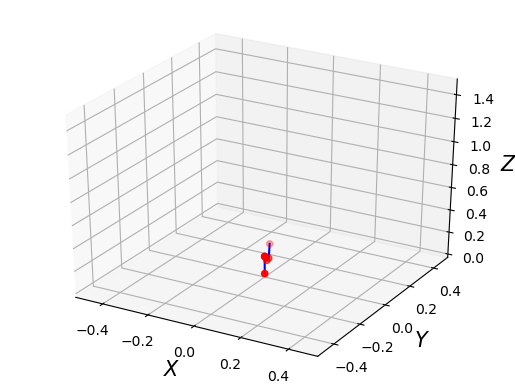

In [21]:
(X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,theta,le=0)
#print(X_cord,Y_cord,Z_cord)
# Plot
fig_1 = Plot.figure()
axis_object_1 = Plot.axes(projection ='3d')
axis_object_1.scatter(X_cord,Y_cord,Z_cord,c='Red')
axis_object_1.plot(X_cord,Y_cord,Z_cord,c='blue')

# Axis Label
axis_object_1.set_xlabel('$X$',fontsize=15)
axis_object_1.set_ylabel('$Y$',fontsize=15)
axis_object_1.set_zlabel('$Z$',fontsize=15)

# Axis Limit
axis_object_1.axes.set_xlim3d(left=-0.5, right=0.5) 
axis_object_1.axes.set_ylim3d(bottom=-0.5, top=0.5) 
axis_object_1.axes.set_zlim3d(bottom=0, top=1.5)

### Forward Kinematics Plot with Slider 

In [7]:
def plot_robot(theta1, theta2, theta3, theta4, theta5, theta6):
    theta = np.hstack((theta1,theta2,theta3,theta4, theta5, theta6))
    # Compute the end-effector position
    (X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,theta,le=0)
    
    # Plot the robot's links
    Plot.axes(projection ='3d')
    
    # Plot the end-effector position
    axis_object_1 = Plot.axes(projection ='3d')
    axis_object_1.scatter(X_cord,Y_cord,Z_cord,c='Red')
    axis_object_1.plot(X_cord,Y_cord,Z_cord,c='blue')
    
    # Axis Label
    axis_object_1.set_xlabel('$X$',fontsize=15)
    axis_object_1.set_ylabel('$Y$',fontsize=15)
    axis_object_1.set_zlabel('$Z$',fontsize=15)
    
    # Axis Limit
    axis_object_1.axes.set_xlim3d(left=-0.5, right=0.5) 
    axis_object_1.axes.set_ylim3d(bottom=-0.5, top=0.5) 
    axis_object_1.axes.set_zlim3d(bottom=0, top=1.5)

    # Show the plot
    Plot.show()

# Use the interact function to create sliders for controlling the joint angles, and call the plot_robot function with the current values of the sliders
interact(plot_robot, theta1=(-np.pi, np.pi), theta2=(-2*np.pi, 2*np.pi), theta3=(-radians(160), radians(160)), theta4=(-2*np.pi, 2*np.pi), theta5=(-2*np.pi, 2*np.pi), theta6=(-2*np.pi, 2*np.pi))

interactive(children=(FloatSlider(value=0.0, description='theta1', max=3.141592653589793, min=-3.1415926535897…

<function __main__.plot_robot(theta1, theta2, theta3, theta4, theta5, theta6)>

## Inverse Jacobian based Control
#### link : https://www.rosroboticslearning.com/jacobian

(7,)
406 (407, 7) (407, 7) (407, 7)


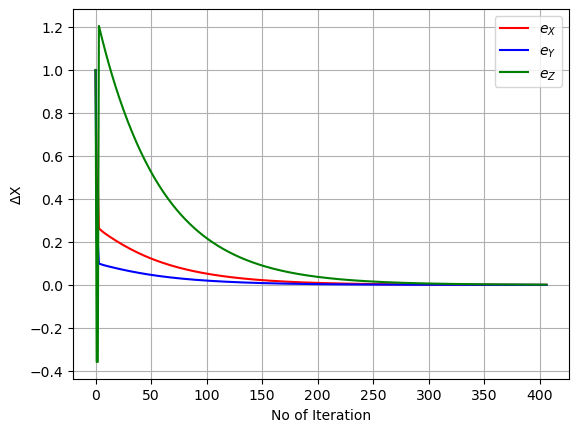

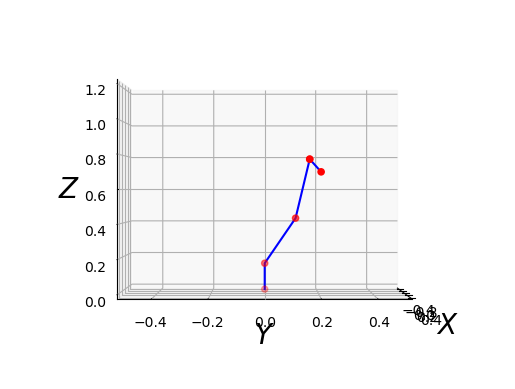

In [11]:
goal_X, goal_Y, goal_Z = 0.5, 0.2, 0.7

i = 0

q = np.reshape(theta,(1,n))  # Im radians

(X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,q[i,:])

print(X_cord.shape)

# Reshape X,Y,Z coord of joint & +1 is for origin->(0,0,0)
X = np.reshape(X_cord,(1,n+1))
Y = np.reshape(Y_cord,(1,n+1))
Z = np.reshape(Z_cord,(1,n+1))

d_X = np.ones((3,1))
while np.max(np.abs(d_X[0:3,i])) > 0.001:

    # Current End-effactor position
    X_c = X[i,-1]
    Y_c = Y[i,-1]
    Z_c = Z[i,-1]

    d_X = np.hstack((d_X, np.array([[goal_X - X_c],[goal_Y - Y_c],[goal_Z - Z_c]])))

    J = jacobian_matrix(n,alpha,a,d,q[i,:])
    Jv_pseudo = np.round(np.linalg.pinv(J[0:3,:]),5)
    q_new = np.degrees(q[i,:]) + np.dot(Jv_pseudo,d_X[:,i+1])  # converted in degrees
    q = np.vstack((q,np.radians(q_new)))  # converted back to radians

    (X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,q[i+1,:])

    i = i + 1

    X = np.vstack((X, np.reshape(X_cord,(1,n+1))))
    Y = np.vstack((Y, np.reshape(Y_cord,(1,n+1))))
    Z = np.vstack((Z, np.reshape(Z_cord,(1,n+1))))
print(i, X.shape, Y.shape, Z.shape)
fig_3 = Plot.figure()
(Row,Column) = d_X.shape

Plot.plot(range(0,Column),d_X[0,0:], 'r-')
Plot.plot(range(0,Column),d_X[1,0:], 'b-')
Plot.plot(range(0,Column),d_X[2,0:], 'g-')

Plot.xlabel('No of Iteration')
Plot.ylabel('$\Delta$X')
Plot.legend(['$e_{X}$','$e_{Y}$','$e_{Z}$'])
Plot.grid()

Plot.show()

fig_4 = Plot.figure()
axis_object_4 = Plot.axes(projection ='3d')

# Axis Label
axis_object_4.set_xlabel('$X$',fontsize=20)
axis_object_4.set_ylabel('$Y$',fontsize=20)
axis_object_4.set_zlabel('$Z$',fontsize=20)

# Axis Limit
axis_object_4.axes.set_xlim3d(left=-0.5, right=0.5) 
axis_object_4.axes.set_ylim3d(bottom=-0.5, top=0.5) 
axis_object_4.axes.set_zlim3d(bottom=0, top=1.2)

axis_object_4.scatter(X[i,:],Y[i,:],Z[i,:],c='Red')
axis_object_4.plot(X[i,:],Y[i,:],Z[i,:],c='blue')
axis_object_4.view_init(0, 0)
Plot.show()

### Weight Function

In [173]:
def weight_Func(m,n,q_range,q,epsilon):
    We = np.zeros((m,m))
    for i in range(0,m):
        We[i,i] = 5

    Wc = np.zeros((n,n))
    for i in range(0,n):
        if q[0,i] < q_range[i,0]:
            Wc[i,i] = 100
        elif q_range[i,0] <= q[0,i] <= (q_range[i,0] + epsilon[0,i]):
            Wc[i,i] = (100/2)*(1 + cos(pi*((q[0,i] - q_range[i,0])/epsilon[0,i])))
        elif (q_range[i,0] + epsilon[0,i]) < q[0,i] < (q_range[i,1] - epsilon[0,i]):
            Wc[i,i] = 0
        elif (q_range[i,1] - epsilon[0,i]) <= q[0,i] <= q_range[i,1]:
            Wc[i,i] = (100/2)*(1 + cos(pi*((q_range[i,1] - q[0,i])/epsilon[0,i])))
        else:
            Wc[i,i] = 100

    Wv = np.zeros((n,n))
    for i in range(0,n):
        Wv[i,i] = 0.5
    
    return We, Wc, Wv

In [174]:
goal_Px, goal_Py, goal_Pz = -0.7, 0.5, 0.2
i = 0
q = np.array([[0,0,0,0,0,0]]) # Hardware & Gazebo Joint Angle at Home Position

joint_offset = np.array([[0, -pi/2, pi/2, 0, 0, 0]])
theta = q + joint_offset # Initial Joint position as per DH convention

Jc = np.eye((n))
q_range = np.radians(np.array([[-360,360],[-360,360],[-150,150],[-360,360],[-360,360],[-360,360]]))
epsilon = 0.5*np.ones(q.shape) # Activation buffer

d_X = np.ones((3,1)) # defining an array to start the loop
while np.max(np.abs(d_X[:,i])) > 0.01:
    if q_range[0,0] > q[0,0] or q[0,0] > q_range[0,1]:
        print('Joint 1 Limit breached')
        break
    elif q_range[1,0] > q[0,1] or q[0,1] > q_range[1,1]:
        print('Joint 2 Limit breached')
        break
    elif q_range[2,0] > q[0,2] or q[0,2] > q_range[2,1]:
        print('Joint 3 Limit breached')
        break
    elif q_range[3,0] > q[0,3] or q[0,3] > q_range[3,1]:
        print('Joint 4 Limit breached')
        break
    elif q_range[4,0] > q[0,4] or q[0,4] > q_range[4,1]:
        print('Joint 5 Limit breached')
        break
    elif q_range[5,0] > q[0,5] or q[0,5] > q_range[5,1]:
        print('Joint 6 Limit breached')
        break
    else:
        pass  

    if i == 0:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:])   # Forward Kinematics
        X,Y,Z = X_cord,Y_cord,Z_cord
    else:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:])   # Forward Kinematics
        X = np.vstack((X,X_cord))
        Y = np.vstack((Y,Y_cord))
        Z = np.vstack((Z,Z_cord))

    Px, Py, Pz = X_cord[n+1],Y_cord[n+1],Z_cord[n+1]

    We, Wc, Wv = weight_Func(3,n,q_range,q,epsilon)

    # Newton Raphson Mathod
    d_X = np.hstack((d_X, np.array([[goal_Px - Px],[goal_Py - Py],[goal_Pz - Pz]])))
    #print('del_X: ',del_X[:,i+1],'\n')
    
    J = jacobian_matrix(n,alpha,a,d,theta[i,:])  # Calculate J
    Je = J[0:3,:]
    Jn = np.linalg.inv(np.transpose(Je) @ We @ Je + np.transpose(Jc) @ Wc @ Jc + Wv) @ np.transpose(Je) @ We

    theta_new = np.degrees(theta[i,:]) + np.reshape(np.dot(Jn,d_X[:,i+1]),(n,)) # In degrees
    q = np.radians(theta_new) - joint_offset # In radians
    theta = np.vstack((theta,np.radians(theta_new))) # In radians

    i = i + 1

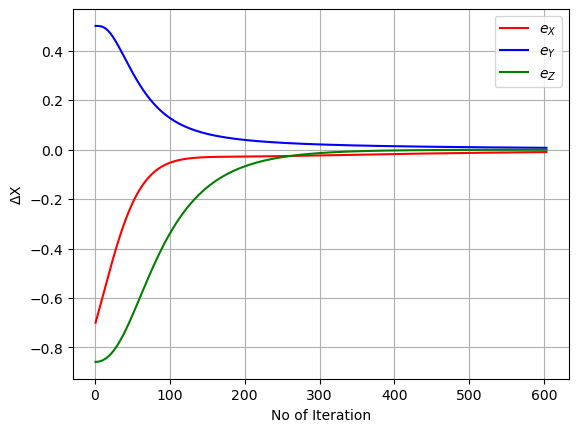

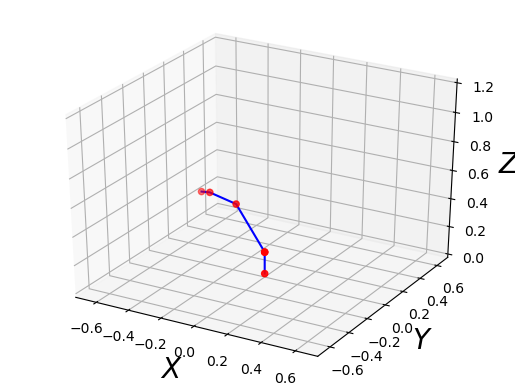

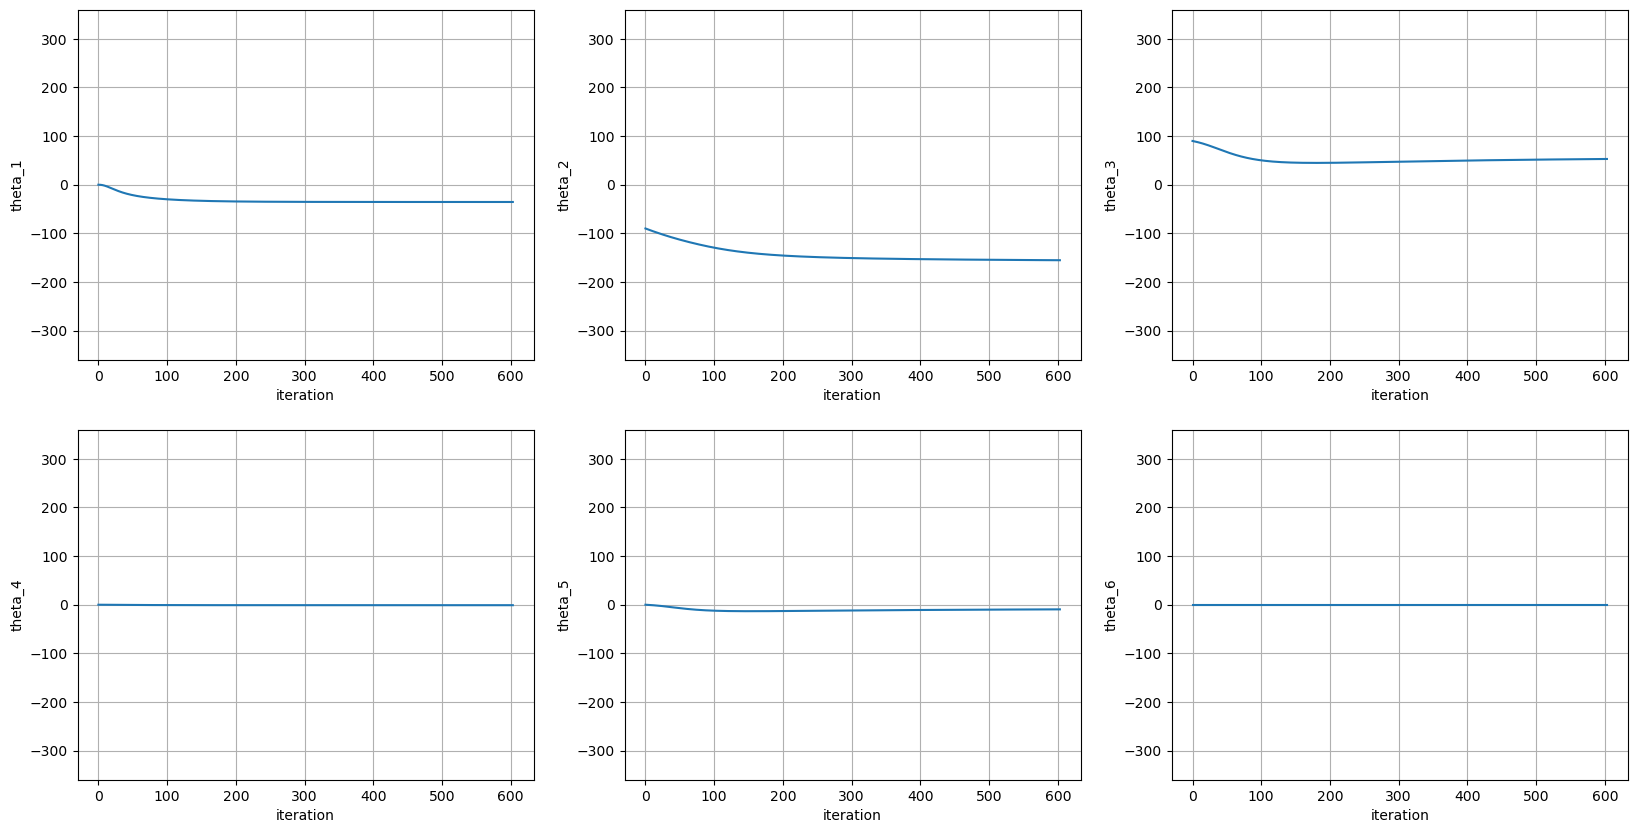

In [175]:
(Row,Column) = d_X.shape

fig_5 = Plot.figure()

Plot.plot(range(1,Column),d_X[0,1:Column], 'r-')
Plot.plot(range(1,Column),d_X[1,1:Column], 'b-')
Plot.plot(range(1,Column),d_X[2,1:Column], 'g-')

Plot.xlabel('No of Iteration')
Plot.ylabel('$\Delta$X')
Plot.legend(['$e_{X}$','$e_{Y}$','$e_{Z}$'])
Plot.grid()

fig_6 = Plot.figure()
axis_object_6 = Plot.axes(projection ='3d')

# Axis Label
axis_object_6.set_xlabel('$X$',fontsize=20)
axis_object_6.set_ylabel('$Y$',fontsize=20)
axis_object_6.set_zlabel('$Z$',fontsize=20)

# Axis Limit
axis_object_6.axes.set_xlim3d(left=-0.7, right=0.7) 
axis_object_6.axes.set_ylim3d(bottom=-0.7, top=0.7) 
axis_object_6.axes.set_zlim3d(bottom=0, top=1.2)

axis_object_6.scatter(X[i-1,:],Y[i-1,:],Z[i-1,:],c='Red')
axis_object_6.plot(X[i-1,:],Y[i-1,:],Z[i-1,:],c='blue')
#axis_object_6.view_init(0, 0)
Plot.show()

# Now plot the data
joints = ['theta_1','theta_2','theta_3','theta_4','theta_5','theta_6']
Plot.figure(figsize=(20,10))
Plot.tight_layout(pad=3.0) # give some spacing btw two subplots
for i in range(1,n+1):
    ax = Plot.subplot(2,3,i) # math.ceil() will round the value to upper limit
    Plot.plot(range(0,Column), np.degrees(theta[:,i-1]))
    Plot.ylim(-360,360)
    Plot.grid()
    Plot.ylabel(joints[i-1])
    Plot.xlabel('iteration')
Plot.show()

### Cost Function

In [16]:
# Initiate
c = np.zeros((n,))
b = np.zeros((n,))
del_phi_del_q = np.zeros((n,))

In [17]:
def cost_func(n,K,q,q_range,m):
    q_c = np.mean(q_range,axis = 1); # column vector containing the mean of each row
    del_q = q_range[:,1] - q_range[:,0]; # Total working range of each joint

    for i in range(0,n):
        if q[0,i] >= q_c[i]:
            c[i] = pow((K[i,i]*((q[0,i] - q_c[i])/del_q[i])),m)
            b[i] = pow((K[i,i]*((q[0,i] - q_c[i])/del_q[i])),m-1)
        elif q[0,i] < q_c[i]:
            c[i] = pow((K[i,i]*((q_c[i] - q[0,i])/del_q[i])),m)
            b[i] = pow((K[i,i]*((q_c[i] - q[0,i])/del_q[i])),(m-1))

    L = np.sum(c)

    for j in range(0,n):
        if q[0,j] >= q_c[j]:
            del_phi_del_q[j] = pow(L,((1-m)/m))*b[j]*(K[j,j]/del_q[j])
        elif q[0,j] < q_c[j]:
            del_phi_del_q[j] = -pow(L,((1-m)/m))*b[j]*(K[j,j]/del_q[j])

    v = -del_phi_del_q
    return v

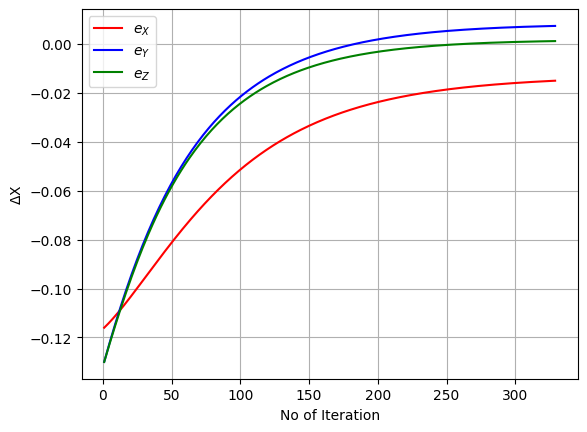

In [20]:
goal_Px, goal_Py, goal_Pz = 0.17, -0.13, 0.075 #0.17, 0.13, 0.1
i = 0
q = np.array([[0,0,0,0]]) # Hardware & Gazebo Joint Angle at Home Position

joint_offset = np.array([[0,1.38544838,-1.38544838,0]])  # Joint angle offset in hardware
theta = q + joint_offset # Initial Joint position as per DH convention
q_range = np.radians(np.array([[-180,180],[-117,90],[-90,87.5],[-103,114.5]])) # range of motion of each joint

m = 5 # mth norm of a vector
Lambda = 0.1 # weights for Singularity avoidance
K = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) # In some practical cases, avoiding joint limit is more important for certain joints, in such cases a weight matrix K is multiplied to the mth norm.

d_X = np.ones((3,1)) # defining an array to start the loop
while np.max(np.abs(d_X[:,i])) > 0.015:

    if q_range[0,0] > q[0,0] or q[0,0] > q_range[0,1]:
        print('Joint 1 Limit breached')
        break
    elif q_range[1,0] > q[0,1] or q[0,1] > q_range[1,1]:
        print('Joint 2 Limit breached')
        break
    elif q_range[2,0] > q[0,2] or q[0,2] > q_range[2,1]:
        print('Joint 3 Limit breached')
        break
    elif q_range[3,0] > q[0,3] or q[0,3] > q_range[3,1]:
        print('Joint 4 Limit breached')
        break
    else:
        pass  

    if i == 0:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:],le)  # Forward Kinematics
        X,Y,Z = X_cord,Y_cord,Z_cord
    else:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:],le)  # Forward Kinematics
        X = np.vstack((X,X_cord))
        Y = np.vstack((Y,Y_cord))
        Z = np.vstack((Z,Z_cord))

    Px, Py, Pz = X_cord[5],Y_cord[5],Z_cord[5]

    V = cost_func(n,K,q,q_range,m)

    # Newton Raphson Mathod
    d_X = np.hstack((d_X, np.array([[goal_Px - Px],[goal_Py - Py],[goal_Pz - Pz]])))

    J = jacobian_matrix(n,alpha,a,d,theta[i,:],le)  # Calculate J
    Je = J[0:3,:]
    
    J1 = np.linalg.inv(np.transpose(Je) @ Je + pow(Lambda,2) * np.eye((n))) @ np.transpose(Je)
    J2 = (np.eye((n)) - J1 @ Je)

    hp = np.transpose(J1 @ d_X[:,i+1]) + np.reshape(np.transpose(J2 @ np.transpose(V)),(4,))

    theta_new = np.degrees(theta[i,:]) + hp # In degrees

    q = np.radians(theta_new) - joint_offset # In radians

    theta = np.vstack((theta,np.radians(theta_new))) # In radians

    i = i + 1

IK_Data_JLA_2 = np.hstack([X,Y,Z])
file = open("IK_Data_JLA_2", "wb")
np.save(file,IK_Data_JLA_2)
file.close

(Row,Column) = d_X.shape

fig_6 = Plot.figure()

Plot.plot(range(1,Column),d_X[0,1:Column], 'r-')
Plot.plot(range(1,Column),d_X[1,1:Column], 'b-')
Plot.plot(range(1,Column),d_X[2,1:Column], 'g-')

Plot.xlabel('No of Iteration')
Plot.ylabel('$\Delta$X')
Plot.legend(['$e_{X}$','$e_{Y}$','$e_{Z}$'])
Plot.grid()

Plot.show()

In [2]:
class My_class:
    def __init__(self):
        self.current = 0

    def __iter__(self):  # pecial methods in Python that enable objects to be used as iterators
        return self  # This method return the iterator object itself 

    def __next__(self):  # provides the next value in the iteration sequence
        if self.current < 5:
            self.current += 1
            return self.current
        else:
            raise StopIteration

My_class_object = My_class()  # create object of the My_class()

for value in My_class_object:  # __init__, method is called when an iteration over an object (My_class_object) is initiated
    print(value)

1
2
3
4
5
